<a href="https://colab.research.google.com/github/jarekwan/jarwan_projekt/blob/main/PROJEKT1_LIGHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJEKT1_LIGHT

Pobrano 250 rekordów
Validated 250 countries successfully
DataFrame utworzony: (250, 795)
      capital    region        subregion      area  population    timezones  \
0  [Kingston]  Americas        Caribbean   10991.0     2961161  [UTC-05:00]   
1    [Moroni]    Africa   Eastern Africa    1862.0      869595  [UTC+03:00]   
2    [Harare]    Africa  Southern Africa  390757.0    14862927  [UTC+02:00]   

                         flags.png                   flags.svg  \
0  https://flagcdn.com/w320/jm.png  https://flagcdn.com/jm.svg   
1  https://flagcdn.com/w320/km.png  https://flagcdn.com/km.svg   
2  https://flagcdn.com/w320/zw.png  https://flagcdn.com/zw.svg   

                                           flags.alt name.common  ...  \
0  The flag of Jamaica is divided by a gold diago...     Jamaica  ...   
1  The flag of Comoros is composed of four equal ...     Comoros  ...   
2  The flag of Zimbabwe is composed of seven equa...    Zimbabwe  ...   

  name.nativeName.mfe.common curren

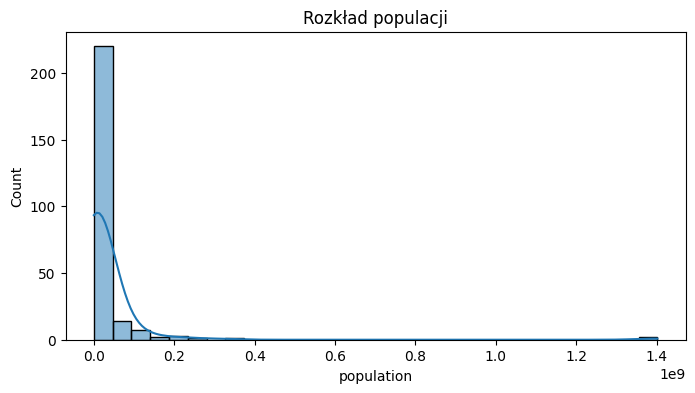

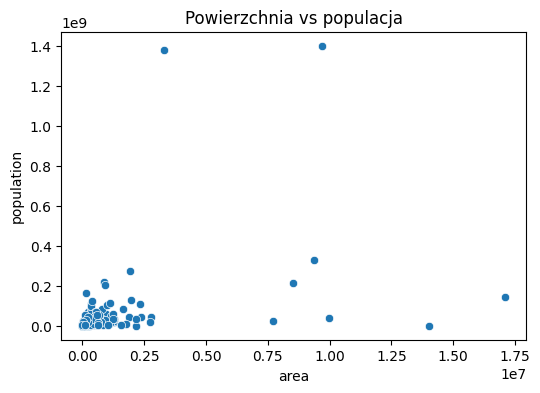

         capital capital_clean
0     [Kingston]      Kingston
1       [Moroni]        Moroni
2       [Harare]        Harare
3  [Philipsburg]   Philipsburg
4    [Vientiane]     Vientiane
5         [Riga]          Riga
6     [Dushanbe]      Dushanbe
7       [London]        London
8      [Managua]       Managua
9     [Khartoum]      Khartoum


In [4]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import List, Dict, Optional
from pydantic import BaseModel, ValidationError

# 1. Pobranie danych z API
url = "https://restcountries.com/v3.1/all?fields=name,capital,region,subregion,population,area,currencies,languages,timezones,flags"
resp = requests.get(url)

if resp.status_code != 200:
    raise Exception(f"Błąd pobierania danych: {resp.status_code}")

data = resp.json()
print(f"Pobrano {len(data)} rekordów")

# 2. Walidacja danych – Pydantic
class Flags(BaseModel):
    png: str
    svg: str
    alt: str

class NativeNameEntry(BaseModel):
    official: str
    common: str

class Name(BaseModel):
    common: str
    official: str
    nativeName: Optional[Dict[str, NativeNameEntry]]

class Currency(BaseModel):
    name: str
    symbol: str



class Country(BaseModel):
    name: Name
    flags: Flags
    currencies: Optional[Dict[str, Currency]]  # This line uses Currency
    capital: List[str]
    region: str
    subregion: Optional[str]
    languages: Dict[str, str]
    area: Optional[float]
    population: int
    timezones: List[str]


# Usage:
try:
    countries = [Country(**item) for item in data]
    print(f"Validated {len(countries)} countries successfully")
except ValidationError as e:
    print(f"Validation error: {e}")

# 3. Zapis/Odczyt JSON
with open("countries_light.json", "w") as f:
    json.dump(data, f, indent=2)

with open("countries_light.json", "r") as f:
    loaded_data = json.load(f)

# 4. DataFrame
df = pd.json_normalize(loaded_data)
print("DataFrame utworzony:", df.shape)
print(df.head(3))

# 5. Walidacja ręczna (proste checki)
invalid_pop = df[~df["population"].apply(lambda x: isinstance(x, int))]
invalid_area = df[~df["area"].apply(lambda x: isinstance(x, (int, float)))]

print(f"Niepoprawne population: {len(invalid_pop)} | area: {len(invalid_area)}")

# 6. Proste statystyki
print("\n📊 Statystyki liczbowe:")
print(df[["population", "area"]].describe())

# NumPy: log + normalizacja
df["log_population"] = np.log1p(df["population"])
df["norm_area"] = (df["area"] - df["area"].min()) / (df["area"].max() - df["area"].min())

# 7. Wizualizacje
plt.figure(figsize=(8,4))
sns.histplot(df["population"], bins=30, kde=True)
plt.title("Rozkład populacji")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="area", y="population")
plt.title("Powierzchnia vs populacja")
plt.show()

# 8. Regex – czyszczenie stolic
def clean_text(val):
    if isinstance(val, list) and val:
        return re.sub(r"[^A-Za-z\s]", "", val[0])
    return val

df["capital_clean"] = df["capital"].apply(clean_text)
print(df[["capital", "capital_clean"]].head(10))
